In [200]:

import pandas as pd


In [201]:

btc_prices = pd.read_csv('/Users/dimmehal/PycharmProjects/twitter_sentiment/data/btc_prices.csv')


In [212]:

import matplotlib.pyplot as plt
import datetime
import numpy as np

def create_plot(x, y):

    plt.plot(x,y)
    plt.show()


In [213]:
def process_price_timeseries(btc_prices, start_date, end_date, window):
    btc_prices['open_time'] =  pd.to_datetime(btc_prices['open_time'], format='%Y-%m-%d %H:%M:%S')
    btc_prices_2 = btc_prices.resample('60min', on='open_time').mean()
    btc_ts = btc_prices[(btc_prices['open_time'] > pd.to_datetime(start_date)) & (btc_prices['open_time'] < pd.to_datetime(end_date))]
    
    # drop and resample every day
    btc_ts.reset_index().drop('index', axis=1)
    btc_ts_2 = btc_ts.resample('D', on='open_time').mean()
    btc_ts_2['rw_avg'] = btc_ts_2['open'].rolling(window=5).mean()
    
    # delta function
    btc_ts_2['delta'] = btc_ts_2['rw_avg'] - btc_ts_2['open'].shift(-1)
    
    # clear up
    ts = btc_ts_2.reset_index()
    ts['id'] = ts.index
    ts = ts[['id', 'rw_avg', 'open_time']]
    
    
def find_minima_maxima(ts):
    from scipy.signal import argrelextrema
    import numpy as np
    n = 5

    ts['min'] = ts.iloc[argrelextrema(ts.rw_avg.values, np.less_equal,
                        order=n)[0]]['rw_avg']
    ts['max'] = ts.iloc[argrelextrema(ts.rw_avg.values, np.greater_equal,
                        order=n)[0]]['rw_avg']
    
    
def simplify_and_correct(ts):
    ts_corrected = ts.fillna(ts.iloc[4].rw_avg)
    ts = ts_corrected.set_index('open_time').drop(columns=['id', 'min', 'max'])
    ts = ts.rw_avg.apply(lambda x: np.log2(x+1))


### Classify high and Lows

In [214]:

# parse dates
btc_prices['open_time'] =  pd.to_datetime(btc_prices['open_time'], format='%Y-%m-%d %H:%M:%S')
# resample every hour
btc_prices_2 = btc_prices.resample('60min', on='open_time').mean()

In [215]:
# Filter for a fixed period
btc_ts = btc_prices[(btc_prices['open_time'] > pd.to_datetime('2021-01-01')) & (btc_prices['open_time'] < pd.to_datetime('2021-09-30'))]


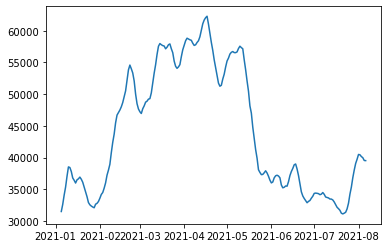

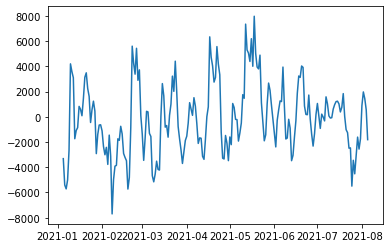

In [216]:
#plot the rolling average w=5 and the discrete derivative
btc_ts.reset_index().drop('index', axis=1)
btc_ts_2 = btc_ts.resample('D', on='open_time').mean()

btc_ts_2['rw_avg'] = btc_ts_2['open'].rolling(window=5).mean()

create_plot(btc_ts_2.index, btc_ts_2.rw_avg)

btc_ts_2['delta'] = btc_ts_2['rw_avg'] - btc_ts_2['open'].shift(-1)
create_plot(btc_ts_2.index, btc_ts_2.delta)


In [217]:
# create a simplified dataframe
ts = btc_ts_2.reset_index()
ts['id'] = ts.index
ts = ts[['id', 'rw_avg', 'open_time']]


In [218]:
#classify high and lows
from scipy.signal import argrelextrema
import numpy as np
n = 5

ts['min'] = ts.iloc[argrelextrema(ts.rw_avg.values, np.less_equal,
                    order=n)[0]]['rw_avg']
ts['max'] = ts.iloc[argrelextrema(ts.rw_avg.values, np.greater_equal,
                    order=n)[0]]['rw_avg']


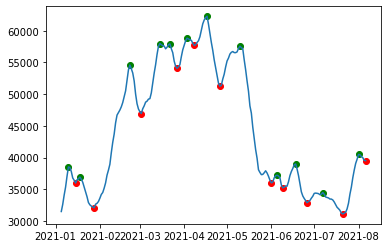

In [219]:
# plot a scatter plots
plt.scatter(ts.open_time, ts['min'], c='r')
plt.scatter(ts.open_time, ts['max'], c='g')

create_plot(ts.open_time, ts.rw_avg)


In [220]:
ts_corrected = ts.fillna(ts.iloc[4].rw_avg)
ts = ts_corrected.set_index('open_time').drop(columns=['id', 'min', 'max'])
ts_non_log = ts
ts = ts.rw_avg.apply(lambda x: np.log2(x+1))

# From here on compute the sentiment series

In [221]:
# now process the actual tweets
tweets = pd.read_json('/Users/dimmehal/PycharmProjects/twitter_sentiment/data/bitcoin_tw.json')


In [222]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def polarity_value_vader(tweets):
    SIA = SentimentIntensityAnalyzer()
    tweets.text = tweets.text.astype(str)
    tweets['sent_value'] = tweets.text.apply(lambda x: SIA.polarity_scores(x))
    sentiment_value = tweets['sent_value'].apply(pd.Series)
    tweets_with_sentiment = pd.concat([tweets.drop(['sent_value'], axis=1), sentiment_value], axis=1)
    return tweets_with_sentiment

In [223]:
tweet_sentiments = polarity_value_vader(tweets)
tweet_sentiments = tweet_sentiments.rename(columns={'created_at':'date'})

In [224]:
def parse_date(tweet_sentiments, name='date'):
    tweet_sentiments[name] = pd.to_datetime(tweet_sentiments[name], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    tweet_sentiments = tweet_sentiments[tweet_sentiments[name].apply(lambda x: x != pd.NaT)]

    tweet_sentiments.sort_values(by=[name])
    return tweet_sentiments

tweet_sentiments = parse_date(tweet_sentiments)


In [225]:
def pre_process_twitter_data(tweet_sentiments, start_date, end_date, frequency, logscale=True):
    
    tweet_info = tweet_sentiments[['date', 'compound']].sort_values(by='date')
    tweet_info.date = tweet_info.date.apply(lambda x: x.floor(frequency))
    # compute mean by day
    mean_compound_by_date = tweet_info.groupby(['date']).mean()
    
    # reset 
    mean_compound_by_date = mean_compound_by_date.reset_index()
    # apply logscale
    if logscale:
        mean_compound_by_date.compound = mean_compound_by_date.compound.apply(lambda x: np.log2(x+1))
    # fill in missing days to create a complete timeline
    mean_compound_by_date.index = pd.DatetimeIndex(mean_compound_by_date.date)
    mean_compound_by_date = mean_compound_by_date.drop('date', axis=1)
    mean_compound_by_date = mean_compound_by_date.asfreq(frequency).fillna(0)
    mean_compound_by_date = mean_compound_by_date[start_date:end_date]
    
    # import to strip the index of timezones to be able to be joined with other timestamps
    mean_compound_by_date.index = mean_compound_by_date.index.tz_localize(None)
    
    return mean_compound_by_date

In [226]:
tweet_sentiments.compound

0      -0.3182
1       0.0000
2       0.0000
3       0.0000
4       0.0000
         ...  
3336    0.6369
3337    0.6369
3338    0.6369
3339    0.6369
3340    0.6369
Name: compound, Length: 3341, dtype: float64

In [189]:
mcbd = pre_process_twitter_data(tweet_sentiments, '2021-01-01', '2021-08-06', 'd')



In [190]:
ts = ts.to_frame()

In [228]:
ts.index.freq = None
ts_non_log.index.freq = None

In [192]:
mcbd_f = mcbd.shift(+1).fillna(0)

In [193]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# here run Granger causality testing


In [229]:
ts = ts_non_log

In [230]:
# # create a simplified dataframe
# ts = btc_ts_2.reset_index()
# ts['id'] = ts.index
# ts = ts[['id', 'rw_avg', 'open_time']]


In [241]:
mod = AutoReg(ts, 6, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 rw_avg   No. Observations:                  218
Model:                     AutoReg(6)   Log Likelihood               -1580.506
Method:               Conditional MLE   S.D. of innovations            418.334
Date:                Sat, 08 Jan 2022   AIC                             12.148
Time:                        06:47:42   BIC                             12.275
Sample:                    01-07-2021   HQIC                            12.199
                         - 08-06-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.5900    134.260      1.300      0.193     -88.555     437.735
rw_avg.L1      1.8810      0.067     28.210      0.000       1.750       2.012
rw_avg.L2     -0.8150      0.143     -5.703      0.0

/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [242]:
pred = res.predict()
pred = pred.to_frame()

def mse(df):
    return (df.rw_avg - df[0])**2

joined = ts.join(pred)
joined['mse'] = joined.apply(mse, axis=1)
joined.sum().mse/joined.shape[0]

/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


170186.91962795638

In [233]:
merge  = ts.join(mcbd_f)
merge

,rw_avg,compound
open_time,,
2021-01-01,31480.538660,0.000000
2021-01-02,31480.538660,0.000000
2021-01-03,31480.538660,0.144851
2021-01-04,31480.538660,0.215567
2021-01-05,31480.538660,0.012354
...,...,...
2021-08-02,40427.306143,0.000000
2021-08-03,40149.829682,0.060278
2021-08-04,39969.854607,0.000000


In [234]:
#slide day by 1, aka we use the previous day as exogenous data    
from statsmodels.tsa.stattools import grangercausalitytests



In [235]:
gc_res = grangercausalitytests(merge, 6)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7543  , p=0.3861  , df_denom=214, df_num=1
ssr based chi2 test:   chi2=0.7648  , p=0.3818  , df=1
likelihood ratio test: chi2=0.7635  , p=0.3822  , df=1
parameter F test:         F=0.7543  , p=0.3861  , df_denom=214, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0728  , p=0.9298  , df_denom=211, df_num=2
ssr based chi2 test:   chi2=0.1490  , p=0.9282  , df=2
likelihood ratio test: chi2=0.1490  , p=0.9282  , df=2
parameter F test:         F=0.0728  , p=0.9298  , df_denom=211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4164  , p=0.7414  , df_denom=208, df_num=3
ssr based chi2 test:   chi2=1.2912  , p=0.7312  , df=3
likelihood ratio test: chi2=1.2873  , p=0.7322  , df=3
parameter F test:         F=0.4164  , p=0.7414  , df_denom=208, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3935  , p=0.8132  

In [239]:
mod = AutoReg(ts, 6, exog=mcbd_f,old_names=False)
res = mod.fit()
print(res.summary())
pred = res.predict()
pred = pred.to_frame()

def mse(df):
    return (df.rw_avg - df[0])**2

joined = ts.join(pred)
joined['mse'] = joined.apply(mse, axis=1)
joined.sum().mse/joined.shape[0]

                            AutoReg Model Results                             
Dep. Variable:                 rw_avg   No. Observations:                  218
Model:                   AutoReg-X(6)   Log Likelihood               -1580.322
Method:               Conditional MLE   S.D. of innovations            417.971
Date:                Sat, 08 Jan 2022   AIC                             12.156
Time:                        06:47:06   BIC                             12.298
Sample:                    01-07-2021   HQIC                            12.213
                         - 08-06-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        176.2351    134.171      1.314      0.189     -86.735     439.205
rw_avg.L1      1.8774      0.067     28.072      0.000       1.746       2.009
rw_avg.L2     -0.8057      0.144     -5.610      0.0

/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/Users/dimmehal/anaconda3/envs/twitter_sentiment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


169891.1110039698

218